# ANN Next Day Market - Time Series Prediction

### Dataset

The goal is to predict electricity prices on the Polish Next Day Market (contracts for the following day) 24 hours in advance

* fixing  - the target price [zł/MWh]
* fixing_1_volume - trading volume for a given hour [MWh]
* hour 
* date 

Auxiliary columns with time-shifted data:
* fixing_minus_1d - data delayed by 24 hours
* ...
* fixing_minus_7d - data delayed by 7 * 24 hours (one week)
* fixing_1_volumne_minus_1d - volume delayed by 24 hours

Remaining data according to PSE https://www.pse.pl/dane-systemowe/plany-pracy-kse/biezacy-plan-koordynacyjny-dobowy-bpkd/wielkosci-podstawowe
* JWCD - centrally dispatched generating units
* nJWCD - others (including, for example, wind energy)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Loading and displaying the dataset

In [13]:
df_train = pd.read_csv('./input/rdn_train.csv', sep=',')
df_test = pd.read_csv('./input/rdn_test.csv', sep=',')

In [14]:
df_train.head()

,date_hour,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie,fixing_minus_1d,fixing_minus_2d,fixing_minus_3d,fixing_minus_4d,fixing_minus_5d,fixing_minus_6d,fixing_minus_7d,fixing_1_volume_minus_1d
0,2018-01-01 00:00:00,117.00,2140.9,0,2018-01-01,15175,22312,9327,6835,8340,3157,1368,98.00,121.03,121.22,125.60,113.52,102.00,70.50,2078.1
1,2018-01-01 01:00:00,113.59,2255.8,1,2018-01-01,14600,22312,9272,6315,8285,3107,1316,82.00,121.03,120.00,120.42,113.00,85.36,70.03,2253.9
2,2018-01-01 02:00:00,97.00,2516.5,2,2018-01-01,14025,22312,9263,5749,8276,3103,1264,76.14,121.03,119.60,116.30,105.00,80.00,70.03,2174.1
3,2018-01-01 03:00:00,89.00,2512.1,3,2018-01-01,13625,22312,9296,5316,8309,3136,1228,74.70,121.03,119.60,116.30,111.39,79.65,70.03,2079.9
4,2018-01-01 04:00:00,75.00,2512.4,4,2018-01-01,13400,22312,9402,4985,8415,3242,1208,73.78,121.03,121.22,119.20,117.54,77.23,70.03,2073.2


In [15]:
df_test.head()

,date_hour,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie,fixing_minus_1d,fixing_minus_2d,fixing_minus_3d,fixing_minus_4d,fixing_minus_5d,fixing_minus_6d,fixing_minus_7d,fixing_1_volume_minus_1d
0,2019-01-01 00:00:00,0,2019-01-01,14975,21978,9044,7057,7918,2419,1348,183.91,184.99,202.55,185.81,178.85,78.75,141.2,2581.3
1,2019-01-01 01:00:00,1,2019-01-01,14400,21978,9421,6105,8295,2796,1297,174.83,178.44,201.10,179.00,167.83,71.99,130.7,2835.9
2,2019-01-01 02:00:00,2,2019-01-01,13875,21978,9790,5211,8664,3170,1249,178.29,176.81,196.72,176.90,160.06,71.00,100.0,2912.0
3,2019-01-01 03:00:00,3,2019-01-01,13425,21978,10135,4416,9009,3515,1209,170.30,171.70,192.00,183.07,158.00,70.50,89.0,2859.3
4,2019-01-01 04:00:00,4,2019-01-01,13225,21978,10417,3934,9291,3807,1191,173.90,175.00,191.71,179.85,162.00,70.50,89.0,2727.2


In [16]:
# Date Formatting
df_train['date_hour'] = df_train['date'] + ' ' + df_train['hour'].astype(str).str.pad(width=2, fillchar='0')
df_train['date_hour'] = pd.to_datetime(df_train['date_hour'], format="%Y-%m-%d %H")
df_train.set_index('date_hour', inplace=True)

### Strong Dependency on Hour and Day of the Week

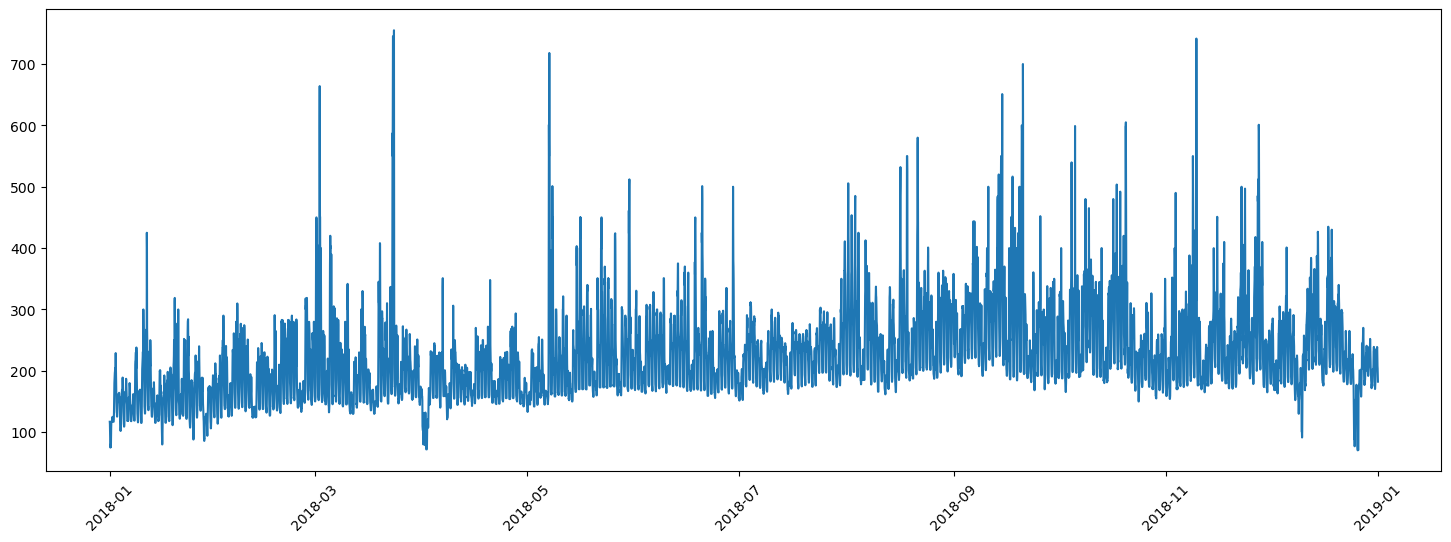

In [18]:
plt.figure(figsize=(18,6))
plt.plot(df_train['fixing'])
plt.xticks(rotation=45);
plt.show()

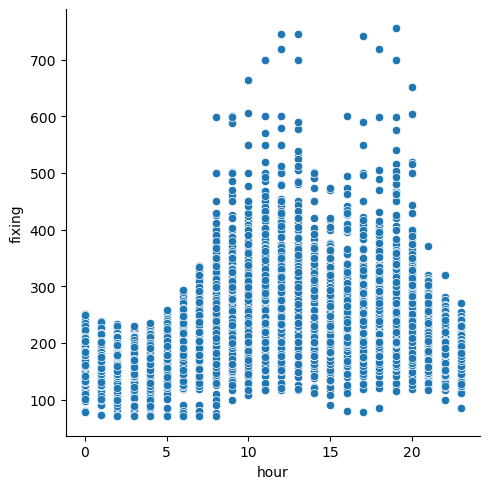

In [19]:
sns.relplot(data=df_train, x='hour', y='fixing');

In [20]:
# List of Columns That Will Be Input Data
cols = ['fixing_minus_7d','fixing_minus_6d','fixing_minus_4d','fixing_minus_3d','hour','Generacja JWCD','Suma zdolności wytwórczych JWCD','Krajowe zapotrzebowanie na moc']

In [21]:
y_train = df_train['fixing']
X_train = df_train[cols]
X_test = df_test[cols]

### Neural Network

https://keras.io/

In [23]:
model = tf.keras.Sequential()


model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(8,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics = [tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'])


C:\Users\Zuzanna\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 86810.5469 - mean_absolute_error: 128.2123 - root_mean_squared_error: 240.9882
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1901.2201 - mean_absolute_error: 30.8260 - root_mean_squared_error: 43.5492
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 1931.8021 - mean_absolute_error: 30.9997 - root_mean_squared_error: 43.8670
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1730.6055 - mean_absolute_error: 29.6612 - root_mean_squared_error: 41.5526
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1539.6270 - mean_absolute_error: 26.6208 - root_mean_squared_error: 39.2015
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1510.2804 - mean_absolute_error: 26.6236 - root_mean_squared_error: 38.8351
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1412.0768 - mean_absolute_error: 26.1967 - root_mean_squared_error: 37.4845
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━

In [25]:
# Model Prediction for Test Data
y_hat = model.predict(X_test)
y_hat

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[143.9249 ],
       [138.11046],
       [107.07279],
       ...,
       [177.02812],
       [171.07219],
       [168.9946 ]], dtype=float32)

In [26]:
# Saving the Result to a CSV File
result = pd.DataFrame(y_hat, columns=['fixing'])
result.to_csv('.//submission.csv', sep=',', index_label='nr')

### Chart of Predicted and True Values (for Training Data)

In [28]:
y_hat_train = model.predict(X_train)
df_plot = pd.DataFrame(y_train)
df_plot['y_hat'] = y_hat_train
# Selecting Date Range
df_plot = df_plot[df_plot.index < '02-01-2018']

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


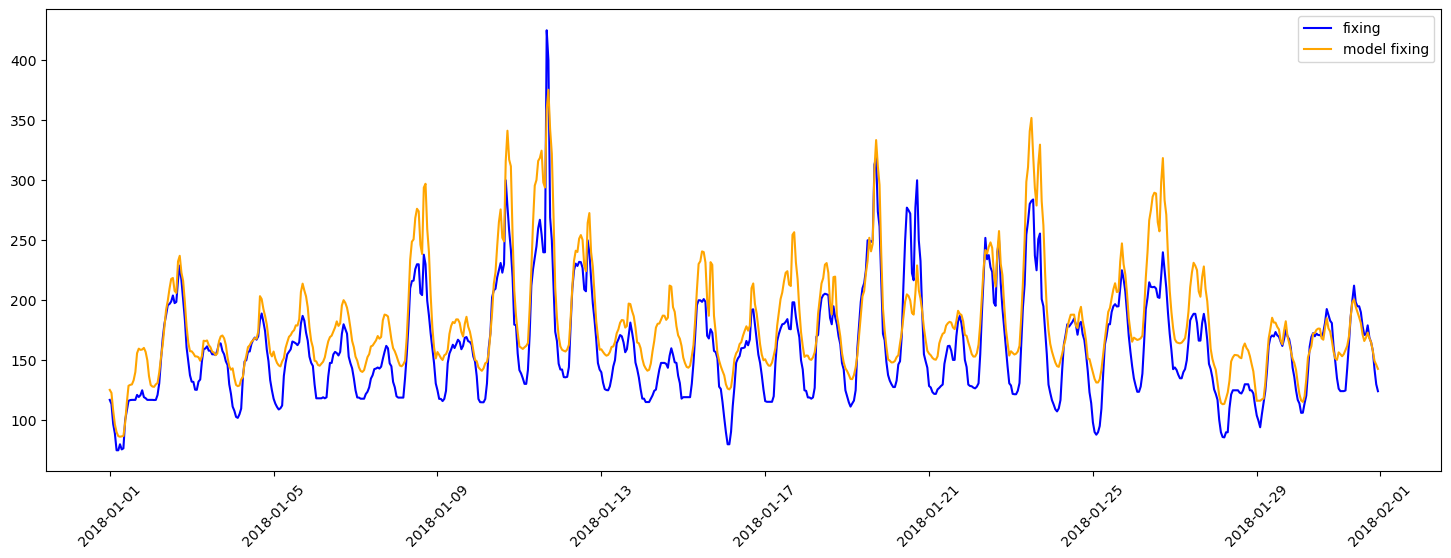

In [29]:
plt.figure(figsize=(18, 6))
plt.plot(df_plot['fixing'], 'blue')
plt.plot(df_plot['y_hat'], 'orange')
plt.xticks(rotation=45);
plt.legend(['fixing', 'model fixing'])